# ARIMA

In [4]:
pip install pmdarima 

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/e7/c7/dcbf0c80920d8674970fef4e89bde7dc439a318a6180fcaa6bd65d8420ef/pmdarima-2.0.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/56/60/db9d17e865559b4ca8b843f6ceffc987054a017ee9b0c967f17928e4cad5/Cython-3.0.8-cp39-cp39-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.2/656.2 kB 22.3 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.9 kB/s eta 0:00:0000:0100:02

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
import pandas as pd
from pmdarima.arima import auto_arima
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
#data_file = '/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv'

#prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/test result/'

quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
data_file =  '/Users/shawn/Flu Forecasting/code/trainingdata_rate0207.csv'

prediction_file = 'ARIMA/submitted result/'

df = pd.read_csv(data_file)
df['fips'] = df['fips'].astype(str).str.zfill(2)
df['Week_end'] = pd.to_datetime(df['Week_end'])
start_date1 = pd.to_datetime('2024-01-27')
df_test = df[(df['Week_end'] >= start_date1) & (df['Week_end'] < pd.to_datetime('2024-01-28'))]
df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-27'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]


df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['rate']
df_train[target] = np.log(df_train[target] + 1)
test_weeks = ['2024-02-10']
test_states = df_train['fips'].unique()

output_data = []
output_data_n = []
quantile_result = pd.DataFrame(columns=['fips', 'Week_end','horizon', 'Quantile', 'Value'])
for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end').copy()


    model = auto_arima(df_state_train[target], seasonal=False, stepwise=True,
                      suppress_warnings=True,
                      error_action="ignore",
                      trace=True,
                      max_order=None,
                      test="adf")


    model = ARIMA(df_state_train[target], order=model.order)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks
        
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)
        residuals = model_fit.resid
        residual_std = np.std(residuals)
        # Approximate quantiles using the forecast values and the standard deviation of residuals
        for horizon in range(0, 4):
            scaled_std = residual_std* np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon ], scale=scaled_std)
            quantile_forecasts = np.exp(quantile_forecasts) - 1
            for q, quantile_forecast in zip(quantiles, quantile_forecasts):
                quantile_result = quantile_result.append({'fips': fips,
                                                        'Week_end': week,
                                                        'horizon': horizon,
                                                        'Quantile': q,
                                                        'Value': max(0, quantile_forecast)}, ignore_index=True)

        # Update the model with the true value from the test set for that week (rolling window)
        #true_value = df_test[(df_test['Week_end'] == week) & (df_test['fips'] == fips)][target].iloc[0]
        #model_fit = model_fit.append(pd.DataFrame({target[0]: [true_value]}, index=[week]))

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)


<ipython-input-14-aea5469892f4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = np.log(df_train[target] + 1)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-11.908, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-23.886, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-35.312, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-13.901, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-37.259, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-25.867, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.229 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=50.151, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=108.089, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=62.560, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=106.096, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=48.452, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=46.514, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=47.477, Time=0.06 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=50.498, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=44.514, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=46.452, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=45.480, Time=0.03 sec
 ARIMA(

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-34.472, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-30.608, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-36.123, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-38.575, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-32.606, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-36.895, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-35.836, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-40.567, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-38.887, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-38.119, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-37.827, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.845 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-17.345, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-28.039, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-36.082, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-19.342, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-34.497, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-38.042, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-37.105, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-36.437, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-30.029, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.026 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-99.806, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-58.533, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-105.061, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-92.728, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.086, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.486, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-103.567, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-101.763, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-107.052, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-105.472, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-105.553, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-94.565, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-103.752, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.704 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-40.353, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-56.827, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-59.032, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-42.344, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-57.337, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-56.002, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-61.032, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-59.333, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-58.826, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-58.002, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.301 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-34.095, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.027, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30.439, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-25.492, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-22.243, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-35.733, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-35.001, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32.468, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-33.733, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-34.432, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36.077, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36.992, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36.156, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-38.809, 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=91.522, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=56.630, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=89.524, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=53.992, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=35.061, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=36.898, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=36.920, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=32.282, Time=0.35 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=34.017, Time=0.26 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=36.110, Time=0.25 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=38.600, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=38.813, Time=0.08 sec
 ARIMA

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-91.776, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-68.001, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-88.307, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-97.440, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-69.997, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-95.615, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-95.605, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-93.737, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-99.417, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-97.587, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-97.576, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-90.294, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-95.712, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.716 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-56.223, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-64.217, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-74.658, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-58.215, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-77.106, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-73.565, Time=0.26 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(1,2,2)(0,0,0)[0] intercept
Total fit time: 1.830 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-49.258, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39.099, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-48.754, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-48.908, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-40.752, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-49.132, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-45.960, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-53.376, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-51.911, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-53.620, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-49.946, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-54.194, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-49.068, Time=0.32 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-50.939, Time=0.33 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-53.2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.794, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5.229, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8.200, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.201, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2.461, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4.179, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4.333, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4.108, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6.110, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=0.537, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3.393, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2.235, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2.399, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2.182, Time=0.03 sec
 ARIMA(3,1,1

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-81.512, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-51.094, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-87.348, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.046, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.564, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-85.355, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-85.356, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-83.359, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-89.275, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-87.285, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-87.287, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.755, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-85.285, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.740 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-62.422, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-52.630, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-59.930, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-59.806, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-54.621, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-56.539, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-57.734, Time=0.15 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-57.937, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-55.641, Time=0.15 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 1.98

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-35.605, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26.936, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.473, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31.421, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.463, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36.999, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36.208, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36.385, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-38.332, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-35.591, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-41.780, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-38.923, Time=0.24 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-48.532, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-45.288, Time=0.13 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-37.7

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-35.952, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-21.336, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-38.789, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-40.852, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-23.336, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-39.495, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-39.486, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-37.523, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-42.849, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-41.489, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-41.479, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-40.783, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-39.516, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.619 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-3.556, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=10.688, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-4.700, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-7.246, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8.696, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-5.450, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-5.390, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-3.456, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-9.239, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-7.446, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-7.387, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-6.695, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-5.451, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.695 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-37.142, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-8.957, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-21.676, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-40.288, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-10.955, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-38.980, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-38.942, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-42.149, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-23.646, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.097 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3.994, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6.318, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.871, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5.633, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.652, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4.305, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2.617, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2.299, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3.219, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4.768, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-3.278, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1.313, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-6.689, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-4.432, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-5.164, Time=0.06 sec
 A

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-69.277, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-59.446, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-68.948, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-73.549, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-61.437, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-71.574, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-71.584, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-69.778, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-75.510, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-73.539, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-73.549, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-70.921, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-71.742, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.742 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-89.669, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35.175, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.158, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-78.884, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36.056, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-93.054, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-91.059, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.072, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-92.820, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-89.099, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-94.733, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-92.020, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-92.747, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-92.770, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-94.5

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-61.241, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-40.858, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.196, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56.743, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-41.861, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-62.895, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-62.728, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-60.957, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-65.849, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-64.609, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-64.435, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58.070, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-62.664, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.697 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-106.217, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.965, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-103.667, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-85.062, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.157, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-105.865, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-104.240, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-107.053, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-108.024, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-108.045, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-103.345, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-106.740, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-106.366, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-109.726, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=22.970, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-6.281, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-13.888, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=20.972, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-10.457, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-15.886, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-8.279, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-12.454, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.075 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-63.761, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.438, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-69.455, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-57.188, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.780, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-67.456, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-67.456, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-65.552, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-71.340, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-69.341, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-69.341, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-58.789, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-67.441, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.773 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15.406, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.478, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11.505, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9.187, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7.072, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14.048, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-12.550, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-13.669, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13.754, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-12.922, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-13.593, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11.231, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11.435, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-16.902, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-15.640,

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=0.296, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=38.153, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=12.231, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=36.169, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 2.531 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-40.304, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16.221, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-37.820, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31.340, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17.877, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36.577, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-34.987, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36.742, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-40.794, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-41.951, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-32.179, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-41.581, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20.868, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11.430, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16.908, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.645, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13.192, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-19.743, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16.172, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-18.919, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-19.554, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16.692, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-21.818, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-23.476, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-17.685, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-21.853, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-24.6

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-60.701, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.023, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.360, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-52.173, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.286, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-55.931, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-57.038, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-64.269, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-63.456, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-64.604, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-64.923, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-62.839, Time=0.1

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=17.264, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=14.945, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8.886, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=15.290, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=3.967, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=7.128, Time=0.08 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2.472, Time=0.21 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=3.805, Time=0.25 sec
 ARIMA(2,2,4)(0,0,0)[0] intercept   : AIC=3.186, Time=0.25 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,2,2)(0,0,0)[

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-112.546, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.772, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-117.219, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-94.300, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-60.385, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-115.269, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-115.256, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-113.580, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-118.968, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-117.004, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-116.995, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-95.304, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-115.344, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.715 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-49.775, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-51.661, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-55.355, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-51.771, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-57.297, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-53.646, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.152 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=35.882, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=90.254, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=60.666, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=88.255, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=37.796, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=34.975, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=35.797, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=38.813, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=36.201, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=34.479, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=35.833, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=32.479, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=36.816, Time=0.03 sec
 AR

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-91.169, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-93.276, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.897, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53.689, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-91.312, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-91.304, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-91.925, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-94.910, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-92.960, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-92.948, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.884, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-93.601, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.816 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-8.446, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4.910, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-8.556, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-13.672, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2.960, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-11.680, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-11.680, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-9.673, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-15.522, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-13.533, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-13.533, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-10.463, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-11.522, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.773 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-46.621, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4.995, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-41.043, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-34.529, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6.647, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-37.374, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-38.565, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-45.619, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-50.298, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-51.984, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-52.975, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-34.219, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-52.456, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-52.063, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-54.789

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-75.915, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53.118, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.982, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-77.229, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-54.409, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-78.071, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-78.238, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-77.215, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-81.814, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-79.886, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-80.028, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-78.830, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-79.021, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.794 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=65.061, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23.772, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8.934, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=63.065, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=13.220, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.666 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-45.385, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-27.640, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-36.120, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-42.472, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-29.639, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-43.471, Time=0.21 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 1.983 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25.842, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20.875, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.480, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21.487, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19.034, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23.477, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.342 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-25.492, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-31.822, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-41.875, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-27.490, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-41.104, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-43.874, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-33.821, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-43.097, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.084 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-121.187, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-116.243, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-118.116, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-122.571, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-118.234, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-124.126, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-123.135, Time=0.20 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-122.288, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-121.442, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-126.117, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-124.570, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-125.132, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-124.285, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0]             : 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-62.093, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-17.492, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-51.819, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-19.492, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0] intercept
Total fit time: 2.114 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7.119, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.336, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14.345, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.604, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11.750, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12.875, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15.388, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8.997, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8.949, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9.401, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13.585, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5.329, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=11.021, Time=0.04 sec
 ARIMA(2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-28.395, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-31.351, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-43.772, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-30.371, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-45.727, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-33.324, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.078 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-71.517, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-41.400, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-70.222, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-60.405, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-43.180, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-68.029, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-66.977, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-63.764, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-70.219, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.617, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-68.373, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-72.216, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-67.756, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-70.120, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.8

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=19.910, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=38.271, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=31.590, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=17.623, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=36.284, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=15.676, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=29.605, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.023 seconds


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-73.128, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.179, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.551, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-61.372, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39.685, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-69.256, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.074, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-68.607, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-74.572, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-69.558, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-72.023, Time=0.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-72.121, Time=0.23 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-71.751, Time=0.17 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-69.538, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-76.5

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: No

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=98.916, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=66.957, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=96.930, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=61.252, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=59.295, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=58.719, Time=0.07 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=60.590, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=56.899, Time=0.24 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIM

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No su

In [10]:
quantile_result

fips    Week_end horizon Quantile      Value
0      01  2024-02-10       0     0.01   1.306831
1      01  2024-02-10       0    0.025   1.467357
2      01  2024-02-10       0     0.05   1.614326
3      01  2024-02-10       0      0.1   1.794668
4      01  2024-02-10       0     0.15   1.923322
...   ...         ...     ...      ...        ...
4595   56  2024-02-10       3     0.85  12.294191
4596   56  2024-02-10       3      0.9  14.476363
4597   56  2024-02-10       3     0.95   18.38658
4598   56  2024-02-10       3    0.975  22.569813
4599   56  2024-02-10       3     0.99  28.581374

[4600 rows x 5 columns]

0

In [18]:
# convert rate to admission
#pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop = pd.read_csv('/Users/shawn/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
#df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)

<ipython-input-18-f1a00d5deb0c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0


In [19]:
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
#quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0207.csv',index = False)
quantile_result1


<ipython-input-19-1d760f061719>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


reference_date           target  horizon target_end_date location  \
0        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
1        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
2        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
3        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
4        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
...             ...              ...      ...             ...      ...   
4595     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4596     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4597     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4598     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4599     2024-02-10  wk inc flu hosp        3      2024-03-02       56   

     output_type output_type_id  value  
0       quantile           0.01     66  
1       quantile          0.025     74  
2       quantile           0.05     81  
3       quantile            0.1     91  
4       quantile           0.15     97  
...          ...            ...    ...  
4595    quantile           0.85     71  
4596    quantile            0.9     84  
4597    quantile           0.95    106  
4598    quantile          0.975    131  
4599    quantile           0.99    166  

[4600 rows x 8 columns]

## plot

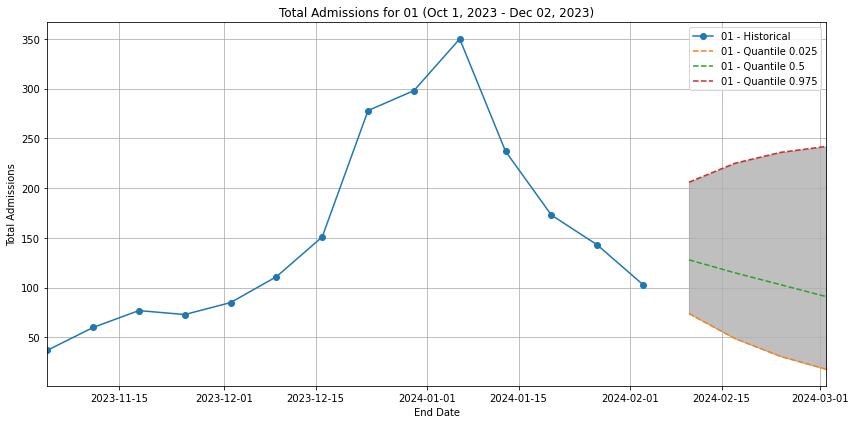

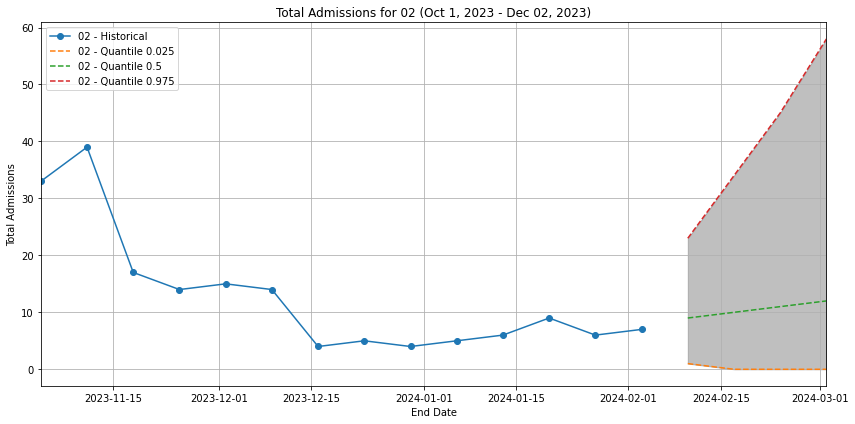

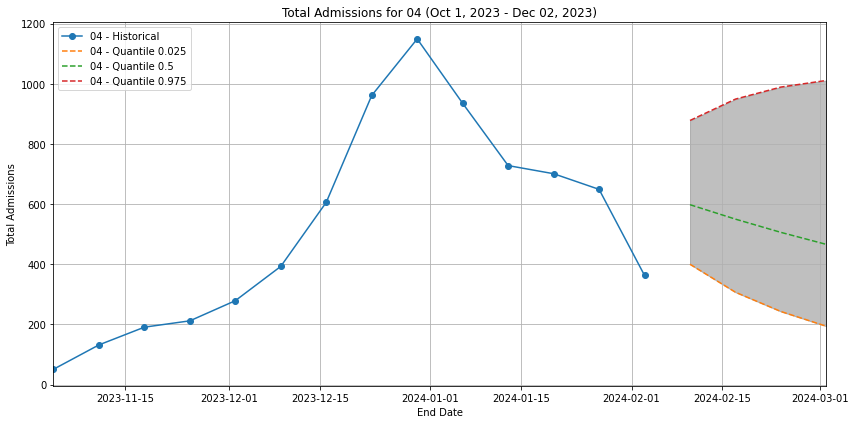

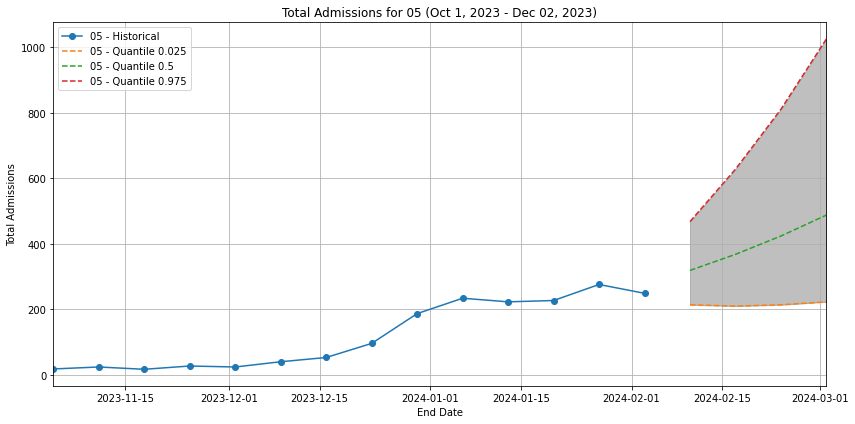

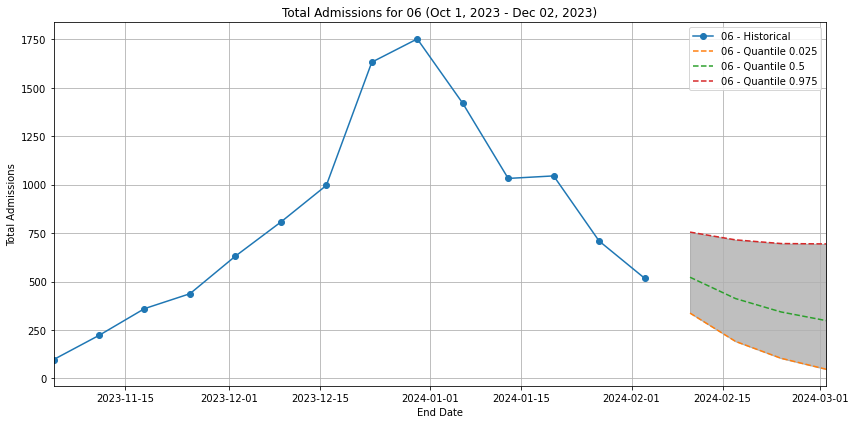

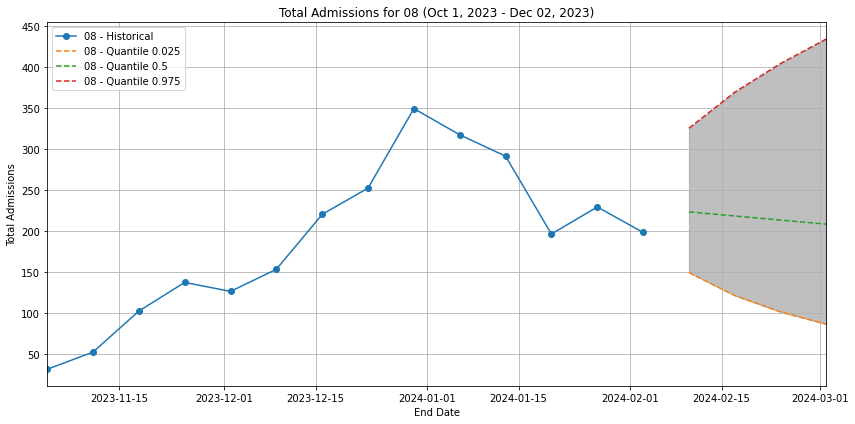

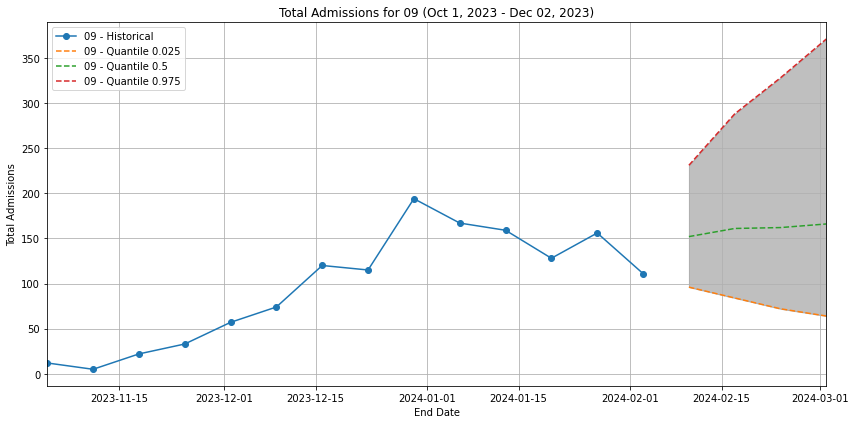

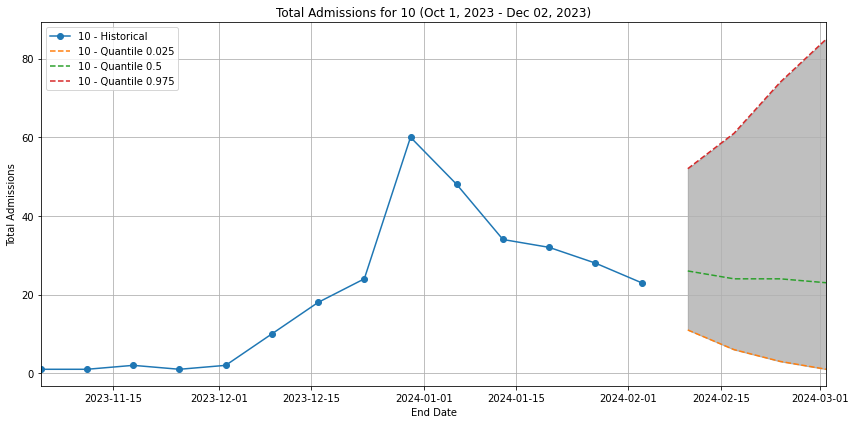

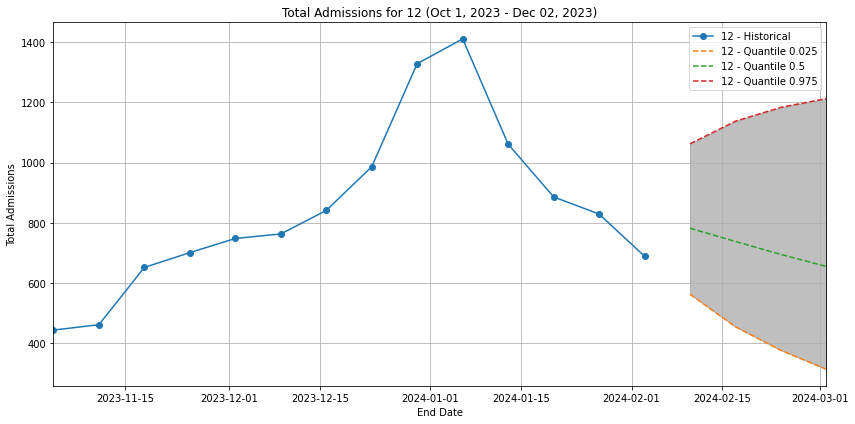

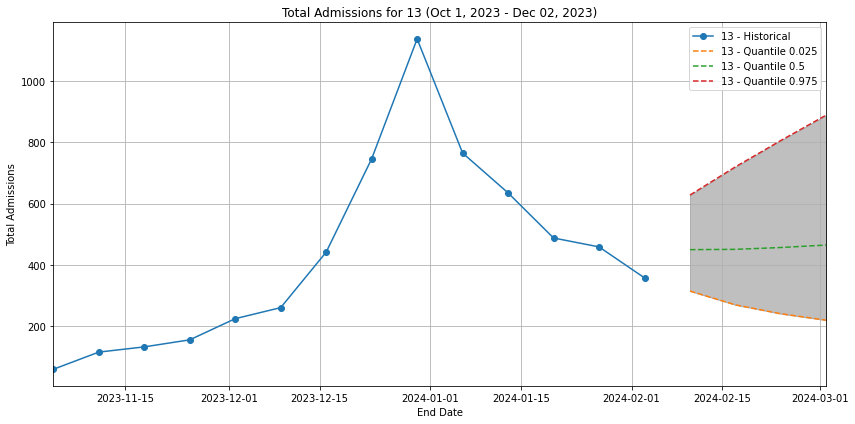

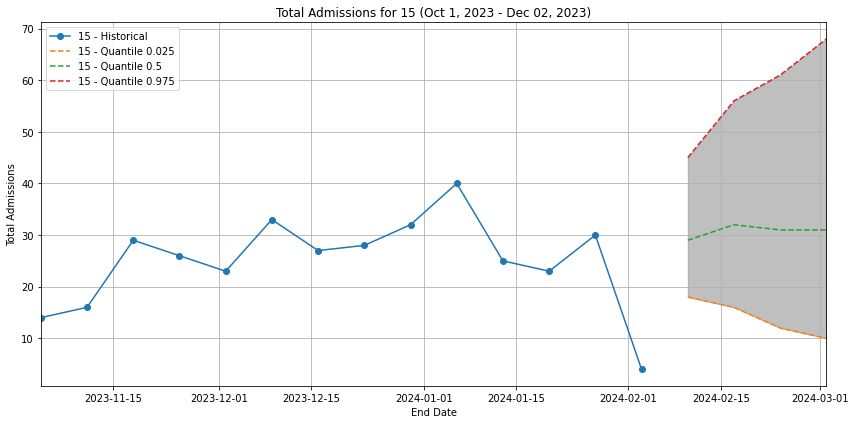

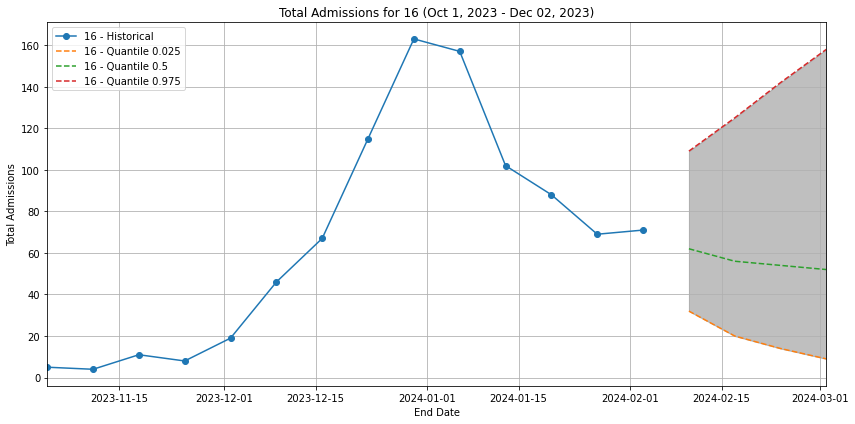

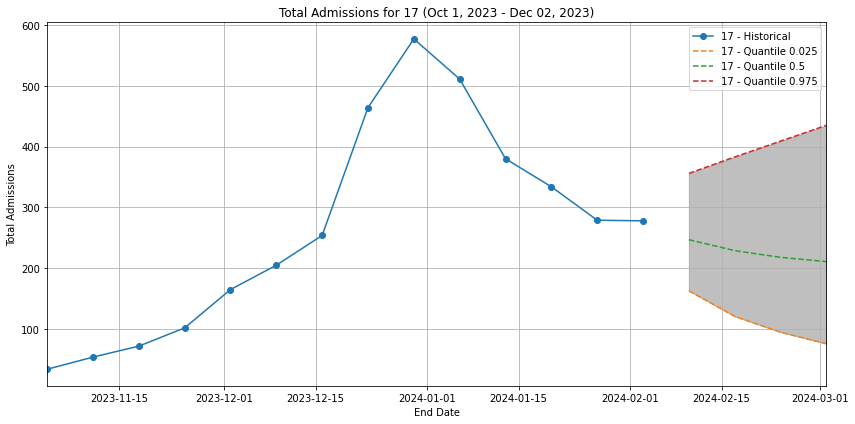

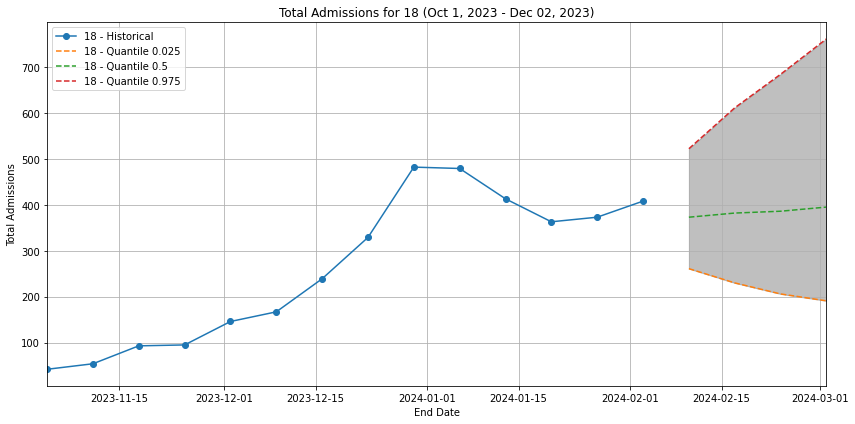

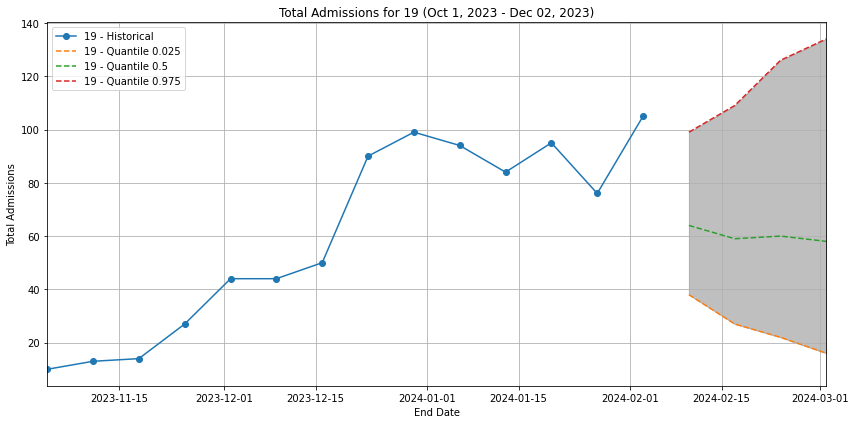

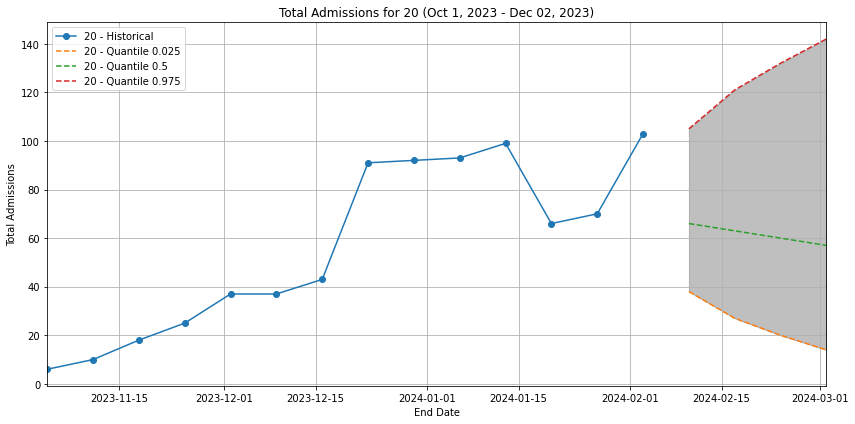

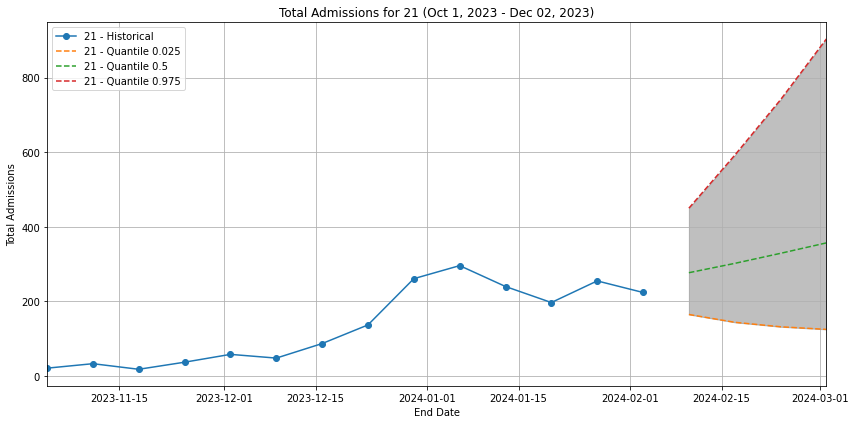

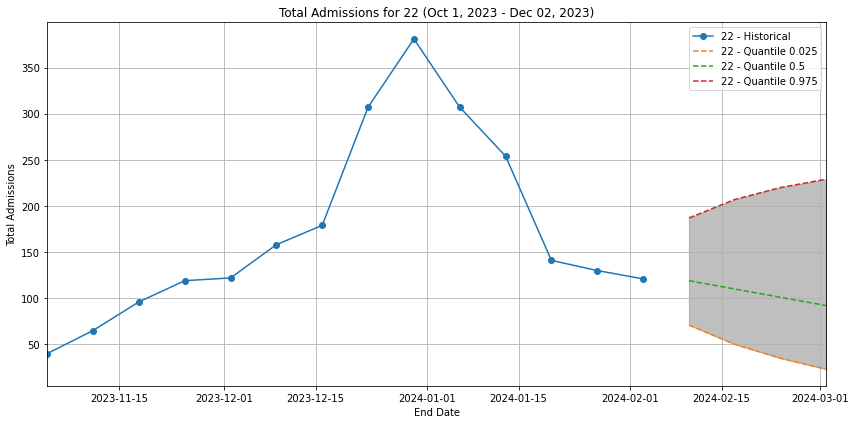

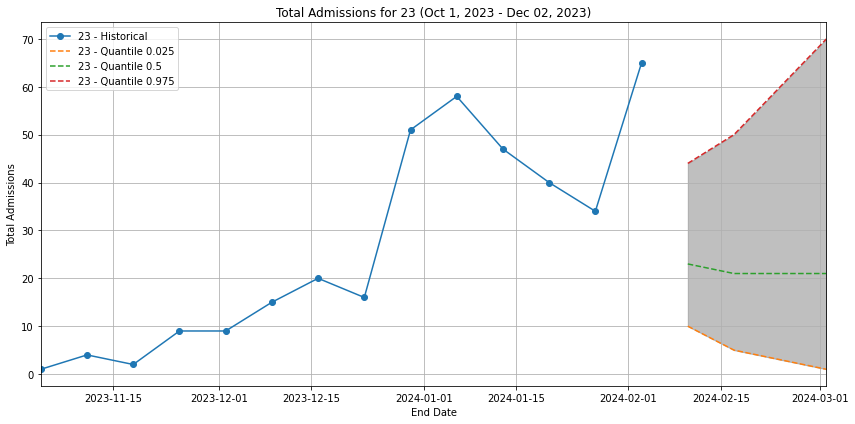

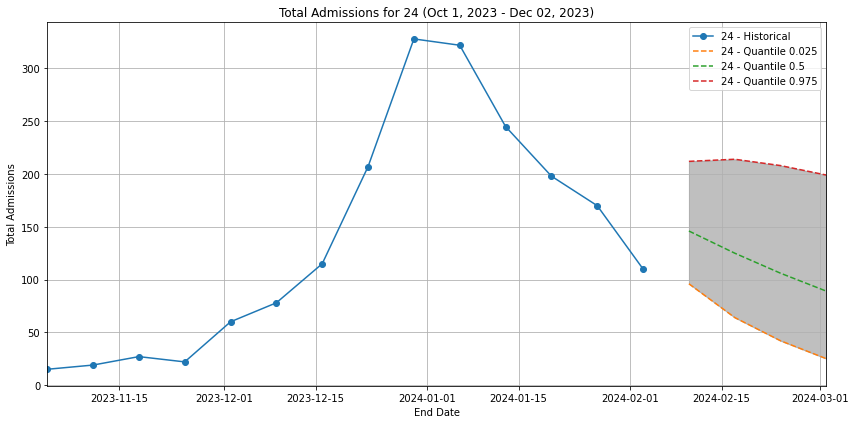

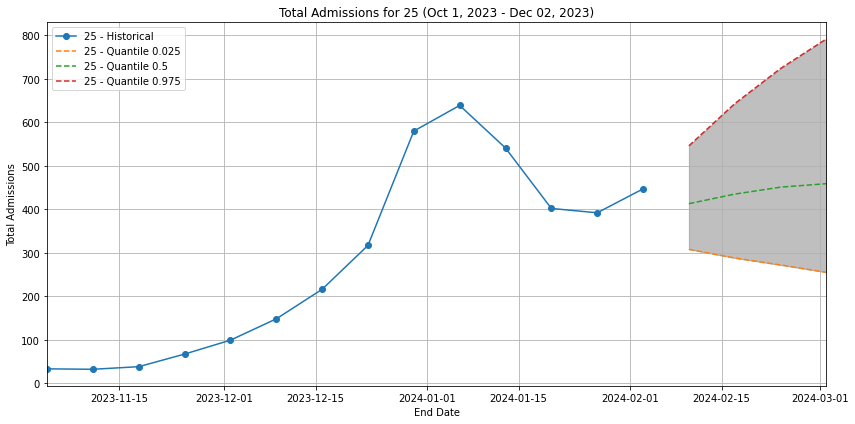

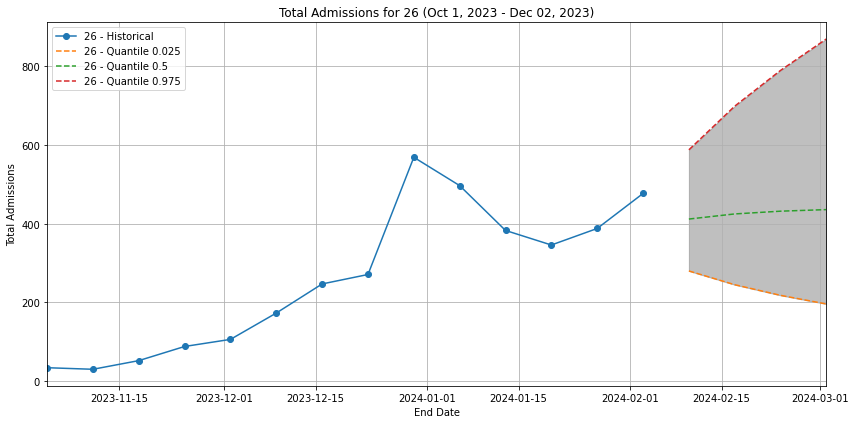

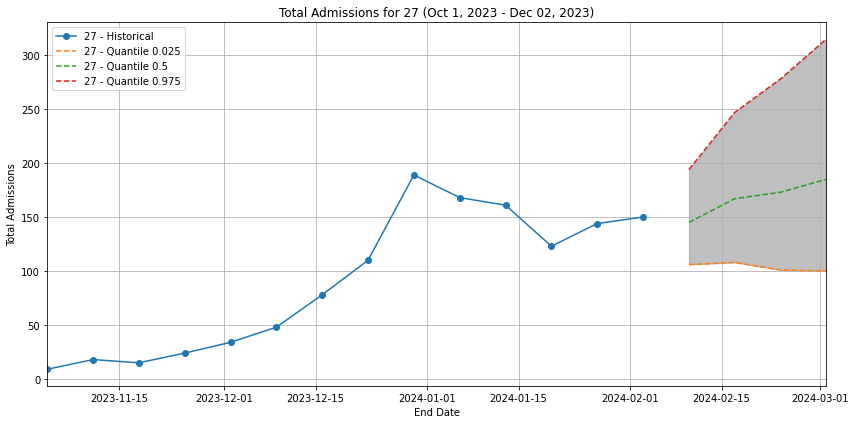

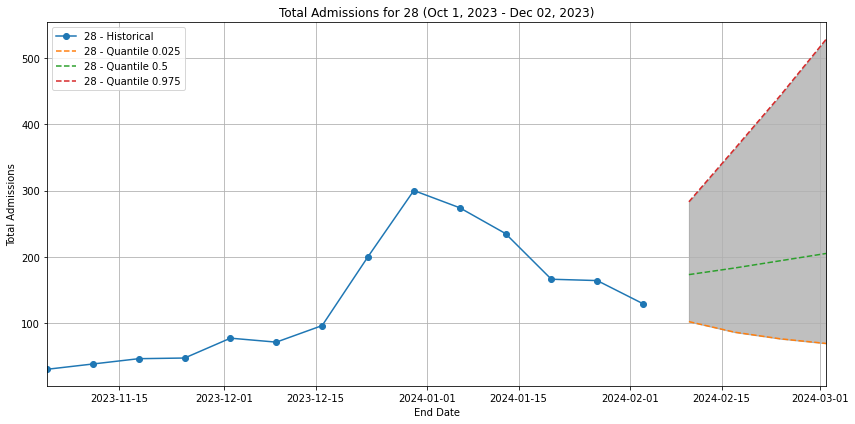

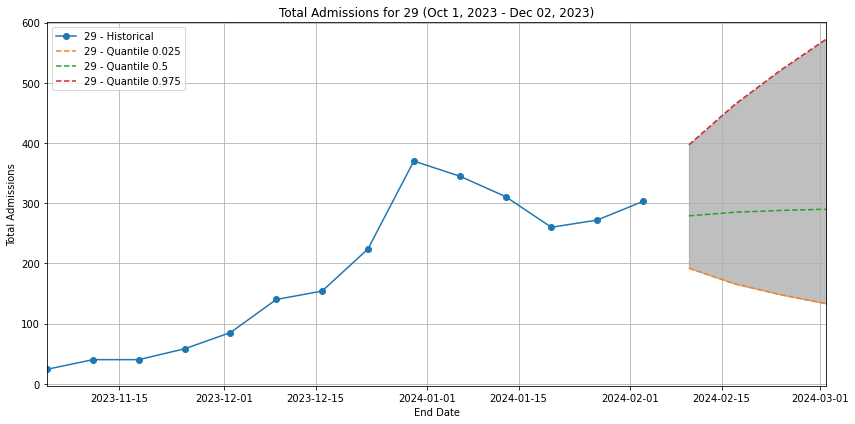

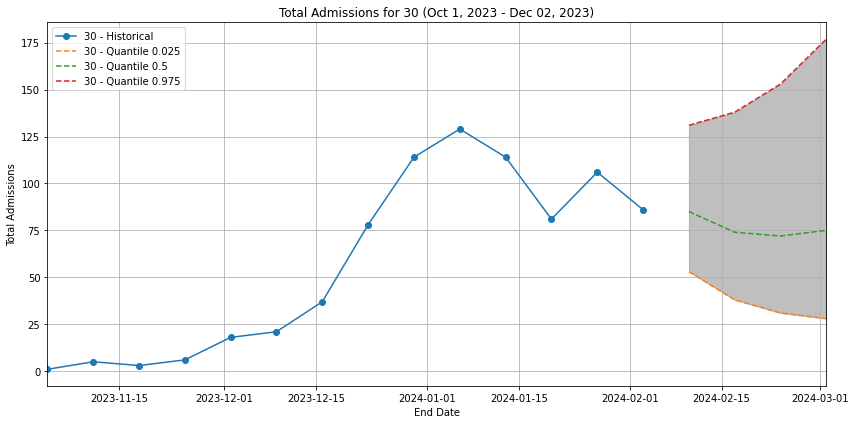

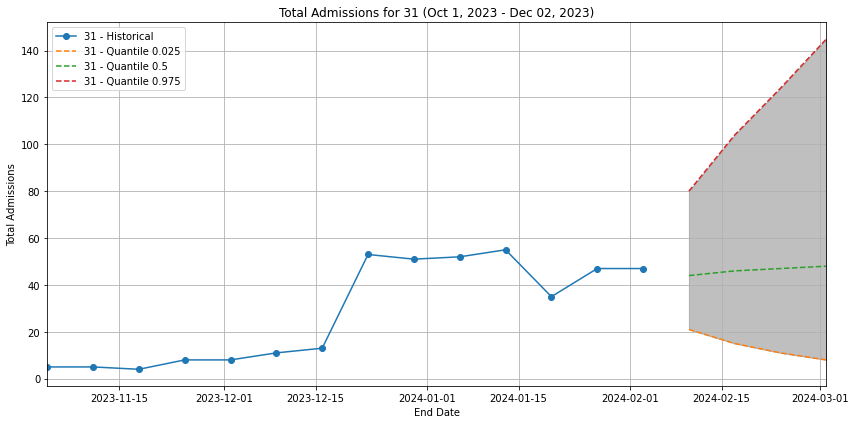

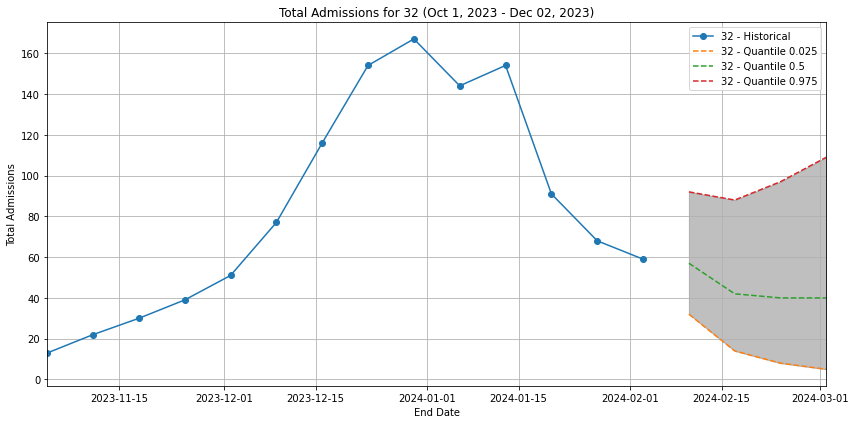

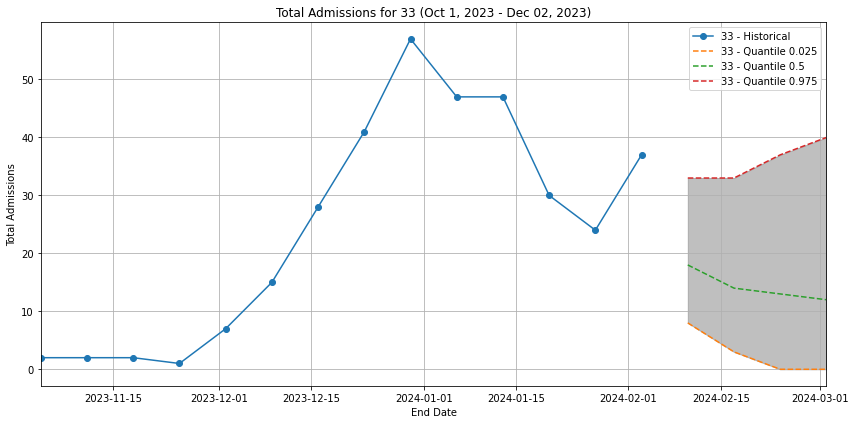

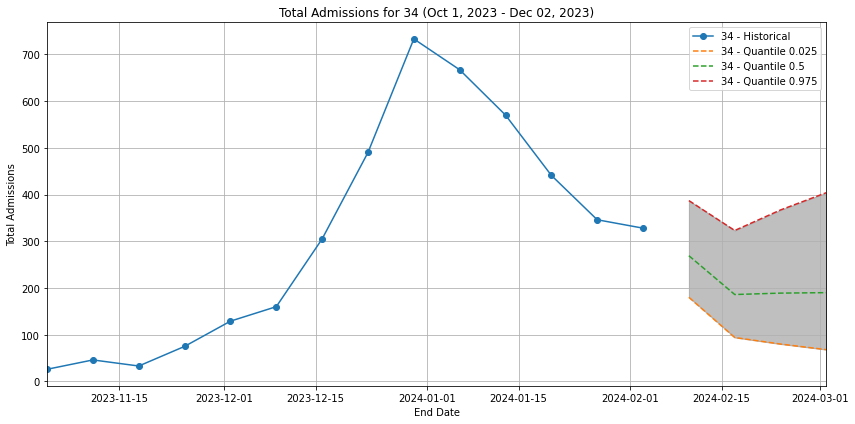

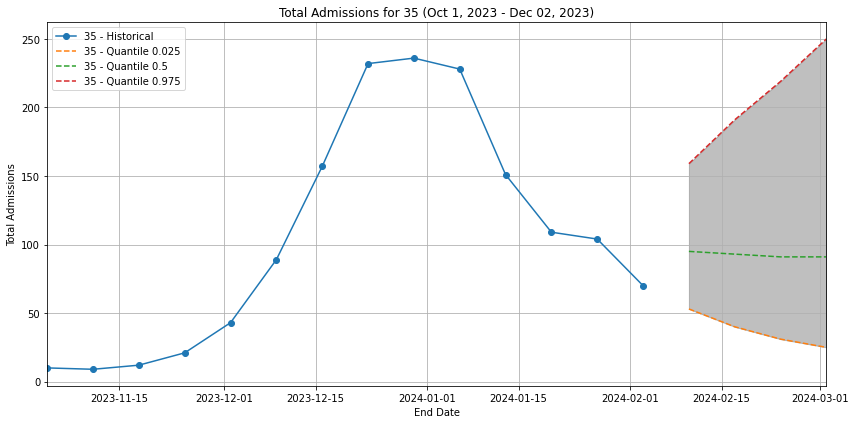

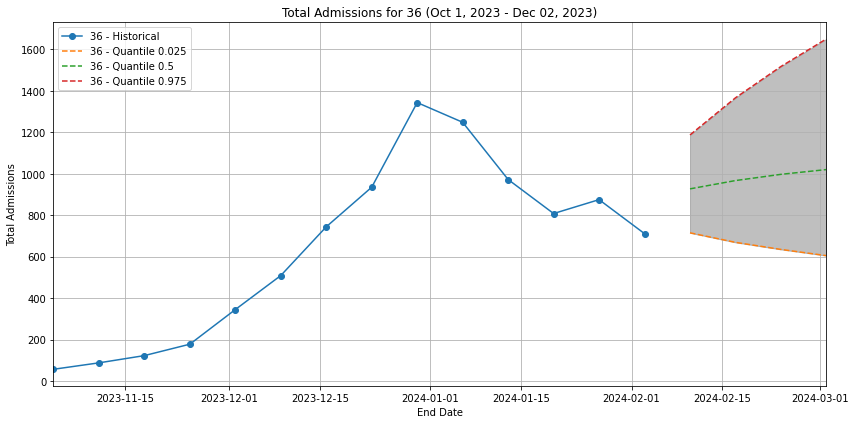

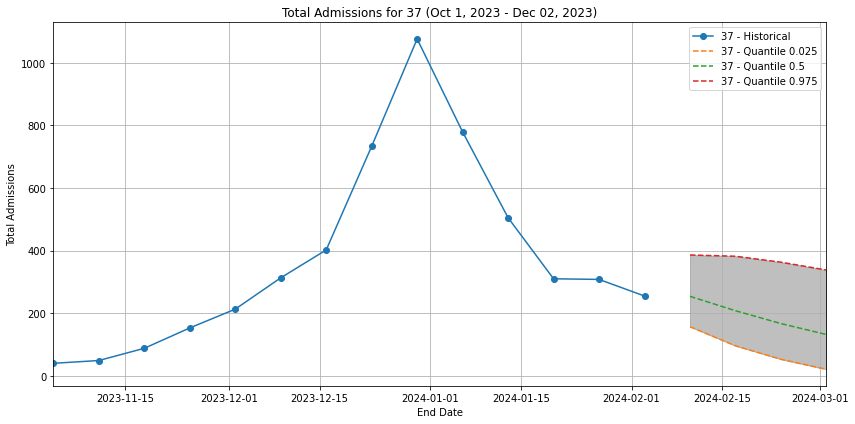

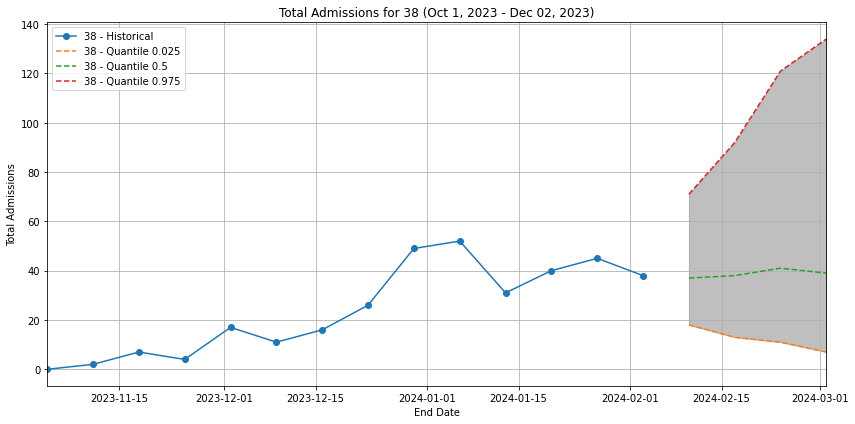

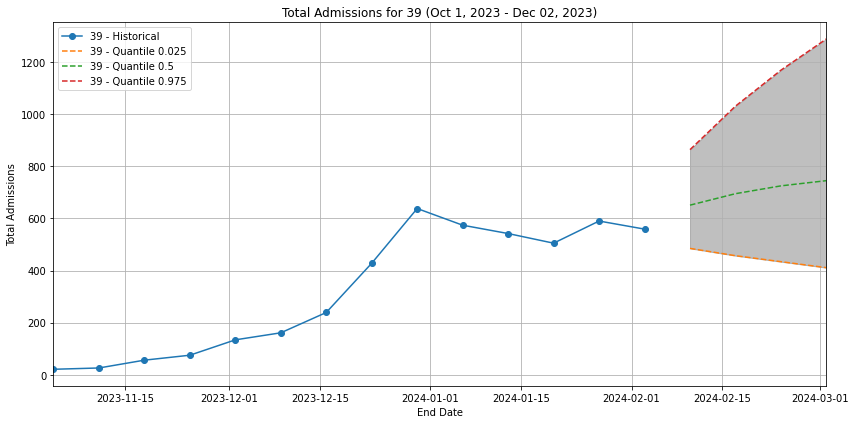

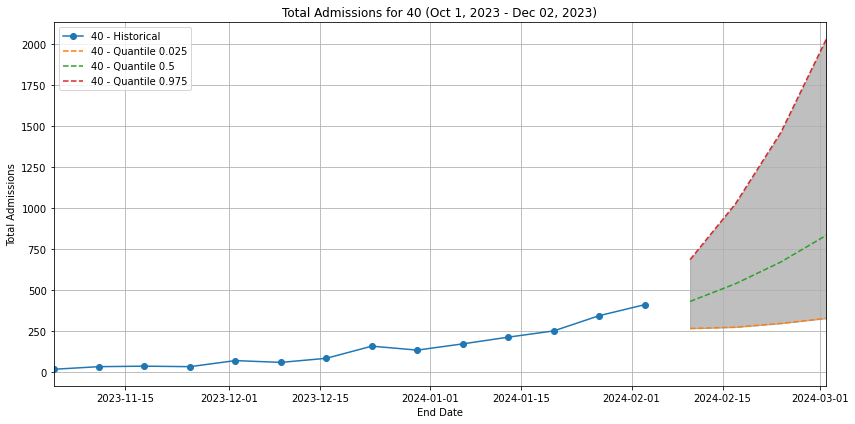

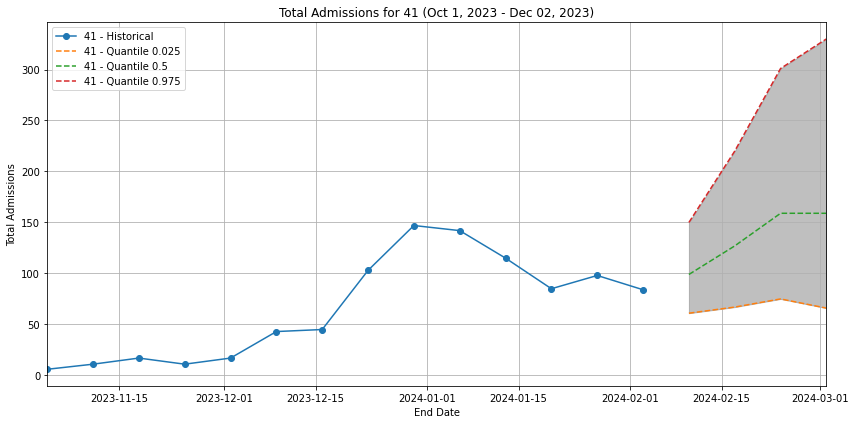

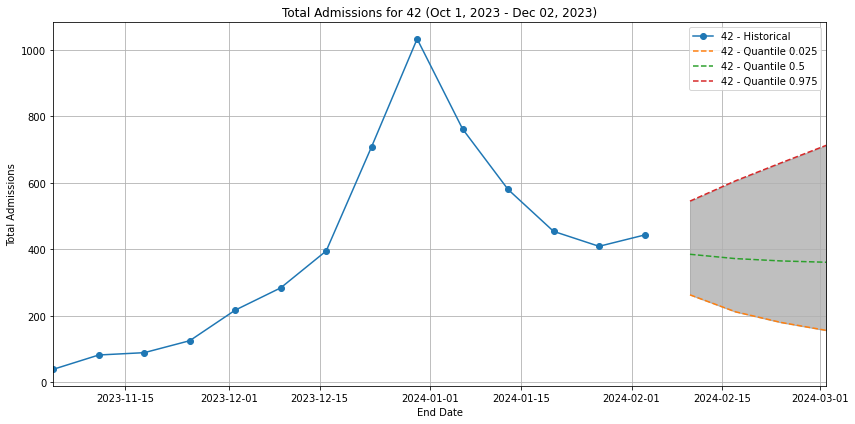

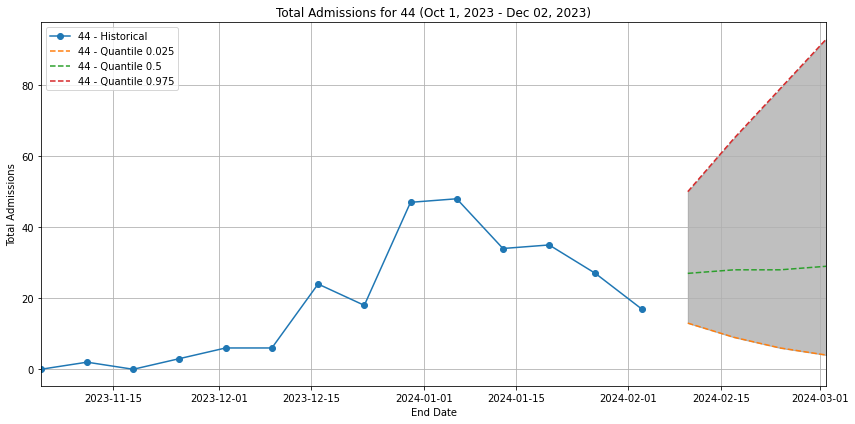

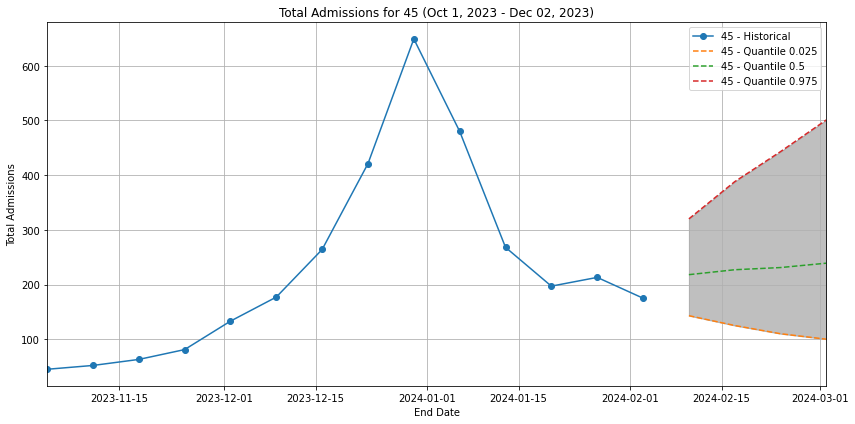

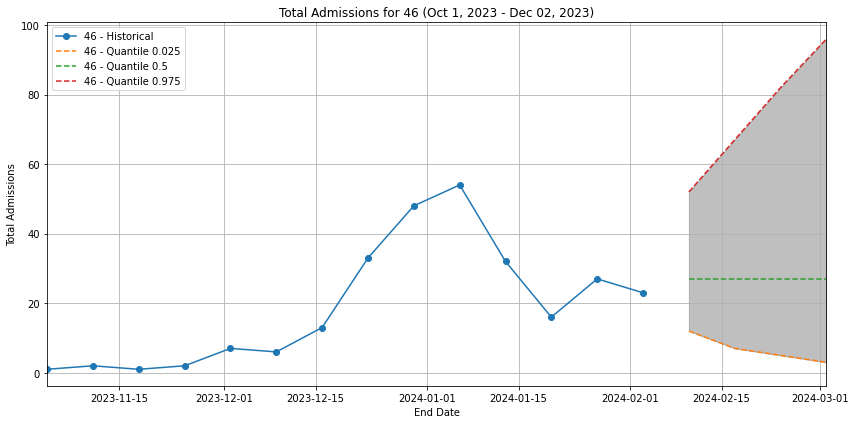

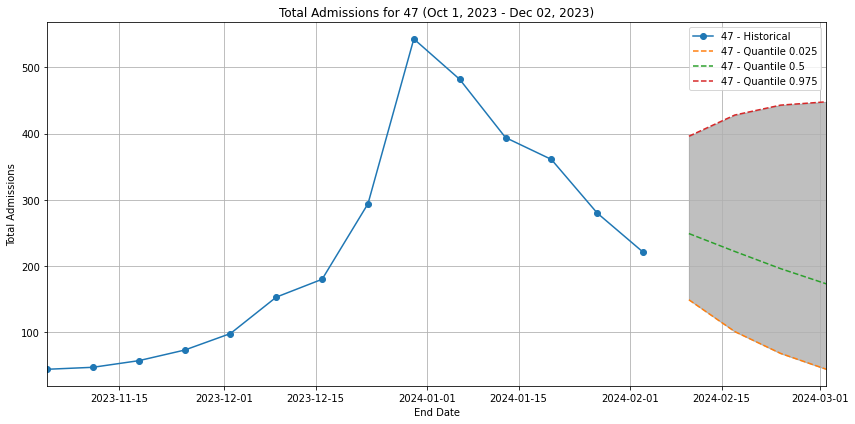

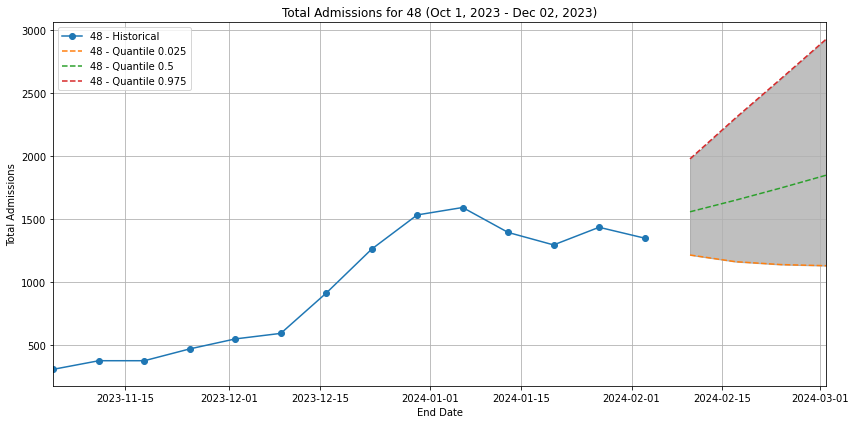

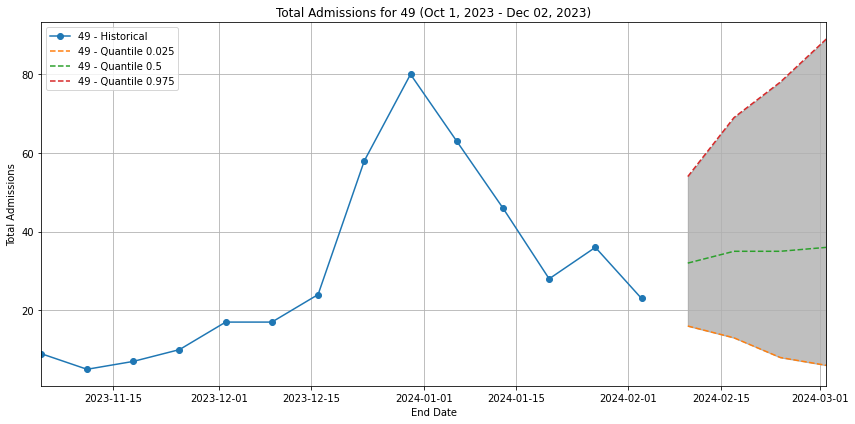

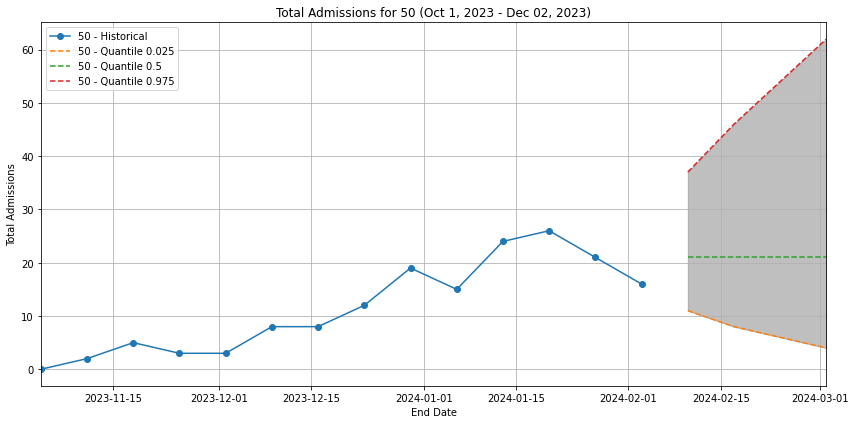

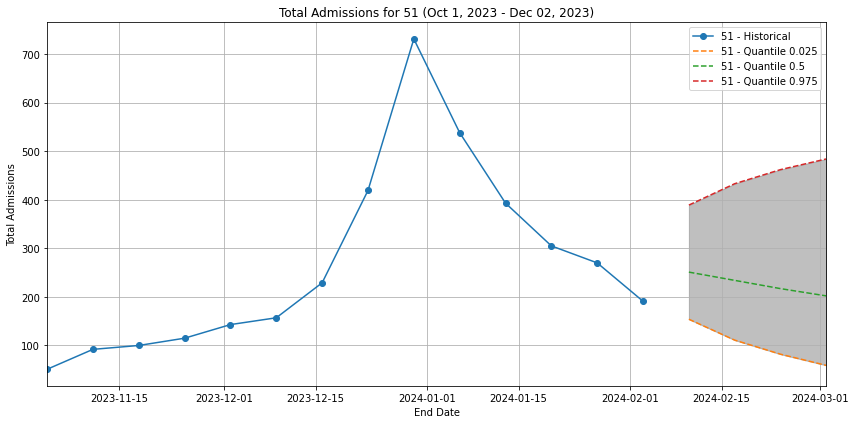

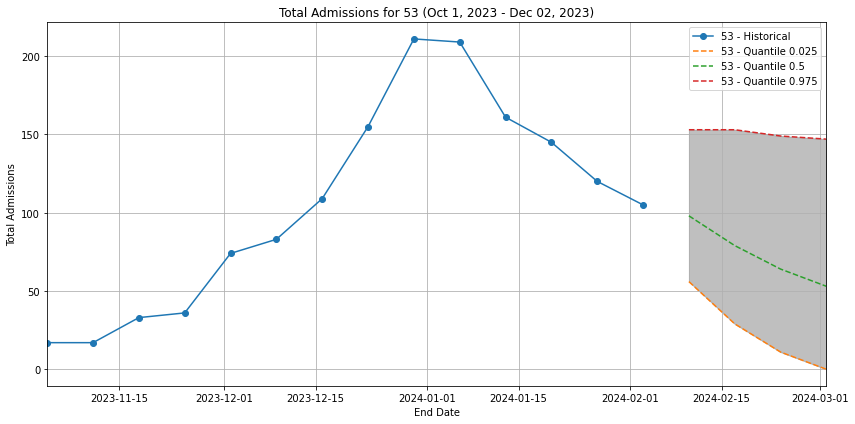

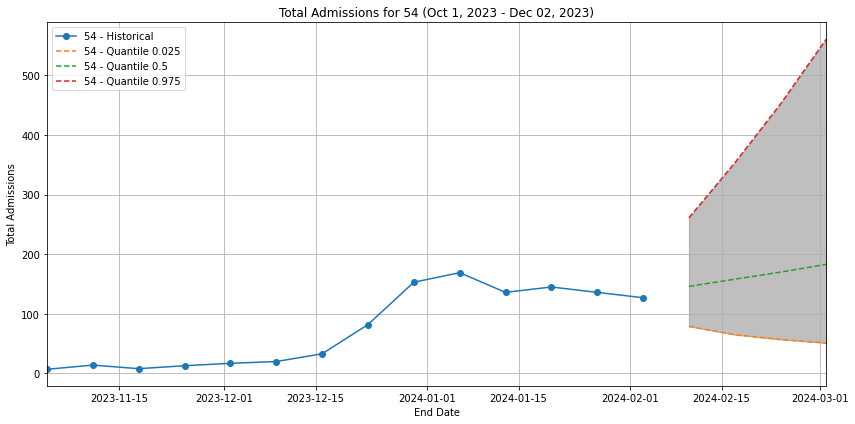

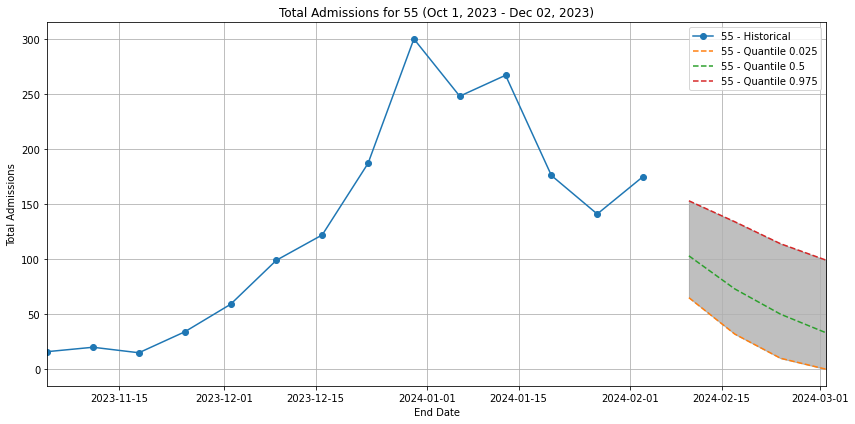

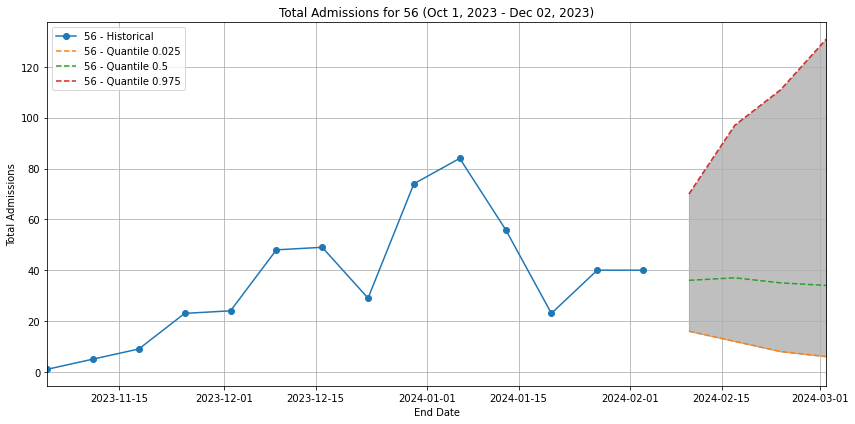

In [20]:
#hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
hist = pd.read_csv('/Users/shawn/Flu Forecasting/code/trainingdata.csv')

import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# exponential smoothing(test)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
data_file =  '/content/drive/MyDrive/Flu Forecasting/code/trainingdata_rate0110.csv'

prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/test result/'

df = pd.read_csv(data_file)
df['fips'] = df['fips'].astype(str).str.zfill(2)
df['Week_end'] = pd.to_datetime(df['Week_end'])
start_date1 = pd.to_datetime('2023-11-01')
df_test = df[(df['Week_end'] > start_date1) & (df['Week_end'] < pd.to_datetime('2023-11-11'))]
df_train = df[(df['Week_end'] <= pd.to_datetime('2023-11-01'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]


df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['rate']
df_train[target] = np.log(df_train[target] + 1)


test_weeks = df_test['Week_end'].unique()
test_states = df_test['fips'].unique()

df_output = pd.DataFrame()
quantile_result = pd.DataFrame()

for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end')


    model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal='add', seasonal_periods=26)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks (including current week)
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)

        forecast_std = np.std(model_fit.resid)

        # Approximate quantiles using the forecast values and the forecast standard deviation
        for horizon in range(0, 4):  # Horizons 0, 1, 2, 3
            scaled_std = forecast_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts_original_scale = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts_original_scale):
                quantile_result = quantile_result.append({
                    'fips': fips,
                    'Week_end': week,
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)}, ignore_index=True)

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)




Streaming output truncated to the last 5000 lines.
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will 

In [ ]:
# convert rate to admission
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)

<ipython-input-2-c26f378c4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0


In [ ]:
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/test result/expresult.csv',index = False)
quantile_result1


<ipython-input-3-102724fda8db>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


location reference_date  horizon  output_type_id  value           target  \
0          01     2023-11-11        0           0.010     22  wk inc flu hosp   
1          01     2023-11-11        0           0.025     26  wk inc flu hosp   
2          01     2023-11-11        0           0.050     29  wk inc flu hosp   
3          01     2023-11-11        0           0.100     33  wk inc flu hosp   
4          01     2023-11-11        0           0.150     36  wk inc flu hosp   
...       ...            ...      ...             ...    ...              ...   
4595       56     2023-11-11        3           0.850     17  wk inc flu hosp   
4596       56     2023-11-11        3           0.900     20  wk inc flu hosp   
4597       56     2023-11-11        3           0.950     24  wk inc flu hosp   
4598       56     2023-11-11        3           0.975     28  wk inc flu hosp   
4599       56     2023-11-11        3           0.990     34  wk inc flu hosp   

     target_end_date output_type  
0         2023-11-11    quantile  
1         2023-11-11    quantile  
2         2023-11-11    quantile  
3         2023-11-11    quantile  
4         2023-11-11    quantile  
...              ...         ...  
4595      2023-12-02    quantile  
4596      2023-12-02    quantile  
4597      2023-12-02    quantile  
4598      2023-12-02    quantile  
4599      2023-12-02    quantile  

[4600 rows x 8 columns]

#### mae

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
desired_dates = ['2023-11-11', '2023-11-18', '2023-11-25', '2023-12-02']
hist = hist[hist['Week_end'].isin(desired_dates)]
hist = hist[['fips','Week_end','total_admissions']]
hist

fips   Week_end  total_admissions
148    01 2023-11-11              60.0
149    01 2023-11-18              77.0
150    01 2023-11-25              73.0
151    01 2023-12-02              85.0
305    02 2023-11-11              39.0
...   ...        ...               ...
7687   55 2023-12-02              59.0
7841   56 2023-11-11               5.0
7842   56 2023-11-18               9.0
7843   56 2023-11-25              23.0
7844   56 2023-12-02              24.0

[200 rows x 3 columns]

In [ ]:
regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
regionresult = regionresult[regionresult['reference_date']=='2023-11-11']
merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

# Calculate the absolute difference between actual and predicted total admissions
merged_df['absolute_difference'] = abs(merged_df['total_admissions'] - merged_df['value'])

# Calculate the Mean Absolute Error (MAE)
mae = merged_df['absolute_difference'].mean()

# Print the MAE
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 30.935


In [ ]:
merged_df

fips   Week_end  total_admissions location reference_date  horizon  \
0     01 2023-11-11              60.0       01     2023-11-11        0   
1     01 2023-11-18              77.0       01     2023-11-11        1   
2     01 2023-11-25              73.0       01     2023-11-11        2   
3     01 2023-12-02              85.0       01     2023-11-11        3   
4     02 2023-11-11              39.0       02     2023-11-11        0   
..   ...        ...               ...      ...            ...      ...   
195   55 2023-12-02              59.0       55     2023-11-11        3   
196   56 2023-11-11               5.0       56     2023-11-11        0   
197   56 2023-11-18               9.0       56     2023-11-11        1   
198   56 2023-11-25              23.0       56     2023-11-11        2   
199   56 2023-12-02              24.0       56     2023-11-11        3   

     output_type_id  value           target target_end_date output_type  \
0               0.5     49  wk inc flu hosp      2023-11-11    quantile   
1               0.5     73  wk inc flu hosp      2023-11-18    quantile   
2               0.5     65  wk inc flu hosp      2023-11-25    quantile   
3               0.5     52  wk inc flu hosp      2023-12-02    quantile   
4               0.5     59  wk inc flu hosp      2023-11-11    quantile   
..              ...    ...              ...             ...         ...   
195             0.5     46  wk inc flu hosp      2023-12-02    quantile   
196             0.5      2  wk inc flu hosp      2023-11-11    quantile   
197             0.5      3  wk inc flu hosp      2023-11-18    quantile   
198             0.5      4  wk inc flu hosp      2023-11-25    quantile   
199             0.5      9  wk inc flu hosp      2023-12-02    quantile   

     absolute_difference  
0                   11.0  
1                    4.0  
2                    8.0  
3                   33.0  
4                   20.0  
..                   ...  
195                 13.0  
196                  3.0  
197                  6.0  
198                 19.0  
199                 15.0  

[200 rows x 12 columns]

## plot

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2023-11-11']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-10-01') & (hist['Week_end'] <= '2023-12-02')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01') & (quantile_data['target_end_date'] <= '2023-12-02')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# exponential smoothing(Prediction)


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
data_file =  '/content/drive/MyDrive/Flu Forecasting/code/trainingdata_rate0207.csv'

prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/'

df = pd.read_csv(data_file)
df['fips'] = df['fips'].astype(str).str.zfill(2)
df['Week_end'] = pd.to_datetime(df['Week_end'])
start_date1 = pd.to_datetime('2024-01-27')
#df_test = df[(df['Week_end'] >= start_date1) & (df['Week_end'] < pd.to_datetime('2024-01-28'))]
df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-27'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]
#df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-27'))]

df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['rate']
df_train[target] = np.log(df_train[target] + 1)


test_weeks = ['2024-02-10']
test_states = df_train['fips'].unique()

df_output = pd.DataFrame()
quantile_result = pd.DataFrame()

for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end')


    #model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal='add', seasonal_periods=52)
    model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal=None)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks (including current week)
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)

        forecast_std = np.std(model_fit.resid)

        # Approximate quantiles using the forecast values and the forecast standard deviation
        for horizon in range(0, 4):  # Horizons 0, 1, 2, 3
            scaled_std = forecast_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts_original_scale = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts_original_scale):
                quantile_result = quantile_result.append({
                    'fips': fips,
                    'Week_end': week,
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)}, ignore_index=True)

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)




Streaming output truncated to the last 5000 lines.
<ipython-input-6-d0efd0e67db1>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-6-d0efd0e67db1>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-6-d0efd0e67db1>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-6-d0efd0e67db1>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-6-d0efd0e67db1>:52: FutureWarning: The frame.append method is deprecated and will 

In [ ]:
quantile_result

fips    Week_end  horizon  Quantile      Value
0      01  2024-02-10        0     0.010   1.550315
1      01  2024-02-10        0     0.025   1.723750
2      01  2024-02-10        0     0.050   1.882318
3      01  2024-02-10        0     0.100   2.076627
4      01  2024-02-10        0     0.150   2.215074
...   ...         ...      ...       ...        ...
4595   56  2024-02-10        3     0.850  15.537987
4596   56  2024-02-10        3     0.900  18.275210
4597   56  2024-02-10        3     0.950  23.187254
4598   56  2024-02-10        3     0.975  28.450757
4599   56  2024-02-10        3     0.990  36.027143

[4600 rows x 5 columns]

In [ ]:
# convert rate to admission
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
#df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)

<ipython-input-8-8652041efc39>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0


In [ ]:
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/quantileresulttest0207.csv',index = False)
quantile_result1


<ipython-input-9-f5356b7255c5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


reference_date           target  horizon target_end_date location  \
0        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
1        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
2        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
3        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
4        2024-02-10  wk inc flu hosp        0      2024-02-10       01   
...             ...              ...      ...             ...      ...   
4595     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4596     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4597     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4598     2024-02-10  wk inc flu hosp        3      2024-03-02       56   
4599     2024-02-10  wk inc flu hosp        3      2024-03-02       56   

     output_type  output_type_id  value  
0       quantile           0.010     79  
1       quantile           0.025     87  
2       quantile           0.050     96  
3       quantile           0.100    105  
4       quantile           0.150    112  
...          ...             ...    ...  
4595    quantile           0.850     90  
4596    quantile           0.900    106  
4597    quantile           0.950    135  
4598    quantile           0.975    165  
4599    quantile           0.990    209  

[4600 rows x 8 columns]

#### mae

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
desired_dates = ['2023-11-11', '2023-11-18', '2023-11-25', '2023-12-02']
hist = hist[hist['Week_end'].isin(desired_dates)]
hist = hist[['fips','Week_end','total_admissions']]
hist

fips   Week_end  total_admissions
148    01 2023-11-11              60.0
149    01 2023-11-18              77.0
150    01 2023-11-25              73.0
151    01 2023-12-02              85.0
305    02 2023-11-11              39.0
...   ...        ...               ...
7687   55 2023-12-02              59.0
7841   56 2023-11-11               5.0
7842   56 2023-11-18               9.0
7843   56 2023-11-25              23.0
7844   56 2023-12-02              24.0

[200 rows x 3 columns]

In [ ]:
regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
regionresult = regionresult[regionresult['reference_date']=='2023-11-11']
merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

# Calculate the absolute difference between actual and predicted total admissions
merged_df['absolute_difference'] = abs(merged_df['total_admissions'] - merged_df['value'])

# Calculate the Mean Absolute Error (MAE)
mae = merged_df['absolute_difference'].mean()

# Print the MAE
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 30.935


In [ ]:
merged_df

fips   Week_end  total_admissions location reference_date  horizon  \
0     01 2023-11-11              60.0       01     2023-11-11        0   
1     01 2023-11-18              77.0       01     2023-11-11        1   
2     01 2023-11-25              73.0       01     2023-11-11        2   
3     01 2023-12-02              85.0       01     2023-11-11        3   
4     02 2023-11-11              39.0       02     2023-11-11        0   
..   ...        ...               ...      ...            ...      ...   
195   55 2023-12-02              59.0       55     2023-11-11        3   
196   56 2023-11-11               5.0       56     2023-11-11        0   
197   56 2023-11-18               9.0       56     2023-11-11        1   
198   56 2023-11-25              23.0       56     2023-11-11        2   
199   56 2023-12-02              24.0       56     2023-11-11        3   

     output_type_id  value           target target_end_date output_type  \
0               0.5     49  wk inc flu hosp      2023-11-11    quantile   
1               0.5     73  wk inc flu hosp      2023-11-18    quantile   
2               0.5     65  wk inc flu hosp      2023-11-25    quantile   
3               0.5     52  wk inc flu hosp      2023-12-02    quantile   
4               0.5     59  wk inc flu hosp      2023-11-11    quantile   
..              ...    ...              ...             ...         ...   
195             0.5     46  wk inc flu hosp      2023-12-02    quantile   
196             0.5      2  wk inc flu hosp      2023-11-11    quantile   
197             0.5      3  wk inc flu hosp      2023-11-18    quantile   
198             0.5      4  wk inc flu hosp      2023-11-25    quantile   
199             0.5      9  wk inc flu hosp      2023-12-02    quantile   

     absolute_difference  
0                   11.0  
1                    4.0  
2                    8.0  
3                   33.0  
4                   20.0  
..                   ...  
195                 13.0  
196                  3.0  
197                  6.0  
198                 19.0  
199                 15.0  

[200 rows x 12 columns]

## plot

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-10']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
quantile_result2

Empty DataFrame
Columns: [location, reference_date, horizon, output_type_id, value, target, target_end_date, output_type]
Index: []

## For DC

In [1]:
import pandas as pd
dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
dc = dc[dc['location'] =='11']
dc['date'] = pd.to_datetime(dc['date'])
dc = dc.drop(columns=['Unnamed: 0'])
dc = dc.sort_values(by='date')
dc

date location         location_name  value  weekly_rate
5466 2022-02-12       11  District of Columbia      0     0.000000
5413 2022-02-19       11  District of Columbia      1     0.149572
5360 2022-02-26       11  District of Columbia      0     0.000000
5307 2022-03-05       11  District of Columbia      1     0.149572
5254 2022-03-12       11  District of Columbia      4     0.598287
...         ...      ...                   ...    ...          ...
219  2024-01-06       11  District of Columbia     55     8.226439
166  2024-01-13       11  District of Columbia     37     5.534150
113  2024-01-20       11  District of Columbia     27     4.038434
60   2024-01-27       11  District of Columbia     21     3.141004
7    2024-02-03       11  District of Columbia     23     3.440147

[104 rows x 5 columns]

In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/'

df = dc.copy()
df = df.rename(columns={'date': 'Week_end', 'location': 'fips'})
start_date1 = pd.to_datetime('2024-02-03')
df_test = df[(df['Week_end'] >= start_date1) & (df['Week_end'] < pd.to_datetime('2024-02-04'))]
#df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-13'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]
df_train = df[(df['Week_end'] <= pd.to_datetime('2024-02-03'))]

df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['weekly_rate']
df_train[target] = np.log(df_train[target] + 1)


test_weeks = ['2024-02-10']
test_states = df_train['fips'].unique()

df_output = pd.DataFrame()
quantile_result = pd.DataFrame()

for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end')


    model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal='add', seasonal_periods=30)
    #model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal=None)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks (including current week)
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)

        forecast_std = np.std(model_fit.resid)

        # Approximate quantiles using the forecast values and the forecast standard deviation
        for horizon in range(0, 4):  # Horizons 0, 1, 2, 3
            scaled_std = forecast_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts_original_scale = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts_original_scale):
                quantile_result = quantile_result.append({
                    'fips': fips,
                    'Week_end': week,
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)}, ignore_index=True)

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
<ipython-input-2-8ee0a3859e0b>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-2-8ee0a3859e0b>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-2-8ee0a3859e0b>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-2-8ee0a3859e0b>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [3]:
quantile_result

fips    Week_end  horizon  Quantile     Value
0    11  2024-02-10        0     0.010  1.322874
1    11  2024-02-10        0     0.025  1.497433
2    11  2024-02-10        0     0.050  1.658020
3    11  2024-02-10        0     0.100  1.856023
4    11  2024-02-10        0     0.150  1.997883
..  ...         ...      ...       ...       ...
87   11  2024-02-10        3     0.850  3.398017
88   11  2024-02-10        3     0.900  3.845768
89   11  2024-02-10        3     0.950  4.594608
90   11  2024-02-10        3     0.975  5.337215
91   11  2024-02-10        3     0.990  6.325459

[92 rows x 5 columns]

In [4]:
# convert rate to admission
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
#df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0207.csv',index = False)
quantile_result1


<ipython-input-4-3197732b6c0d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0
<ipython-input-4-3197732b6c0d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


reference_date           target  horizon target_end_date location  \
0      2024-02-10  wk inc flu hosp        0      2024-02-10       11   
1      2024-02-10  wk inc flu hosp        0      2024-02-10       11   
2      2024-02-10  wk inc flu hosp        0      2024-02-10       11   
3      2024-02-10  wk inc flu hosp        0      2024-02-10       11   
4      2024-02-10  wk inc flu hosp        0      2024-02-10       11   
..            ...              ...      ...             ...      ...   
87     2024-02-10  wk inc flu hosp        3      2024-03-02       11   
88     2024-02-10  wk inc flu hosp        3      2024-03-02       11   
89     2024-02-10  wk inc flu hosp        3      2024-03-02       11   
90     2024-02-10  wk inc flu hosp        3      2024-03-02       11   
91     2024-02-10  wk inc flu hosp        3      2024-03-02       11   

   output_type  output_type_id  value  
0     quantile           0.010      9  
1     quantile           0.025     10  
2     quantile           0.050     11  
3     quantile           0.100     12  
4     quantile           0.150     13  
..         ...             ...    ...  
87    quantile           0.850     23  
88    quantile           0.900     26  
89    quantile           0.950     31  
90    quantile           0.975     36  
91    quantile           0.990     42  

[92 rows x 8 columns]

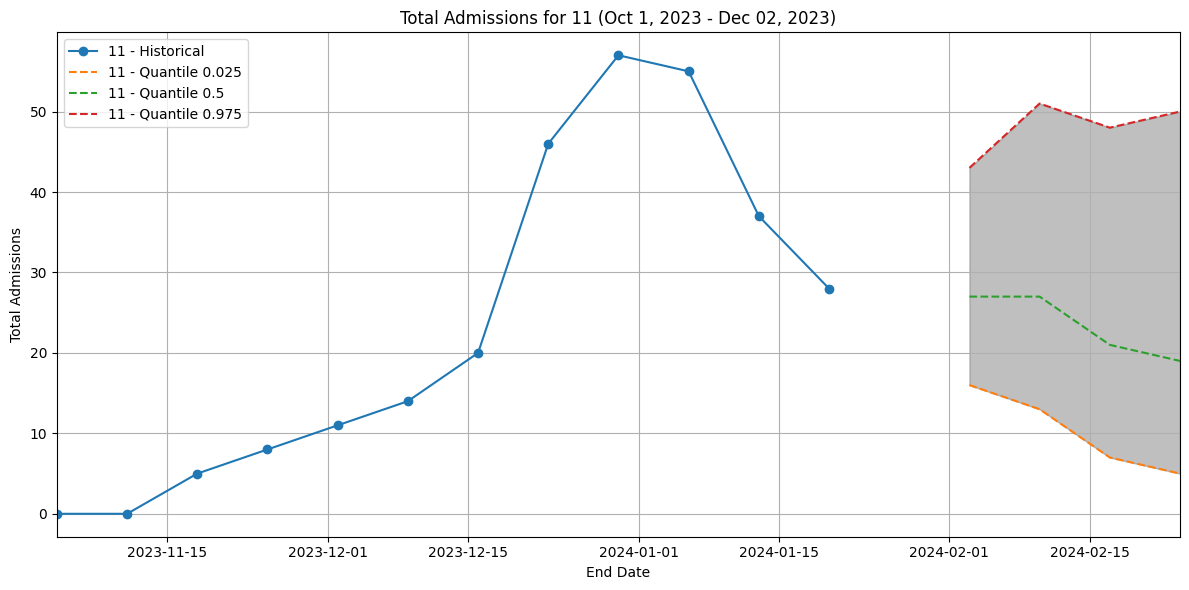

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
hist = dc.copy()
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})


quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-02-03']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
